In [1]:
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
import scipy.spatial.distance as dist

import IBloFunMatch_inter as ibfm
output_dir = "output/"

In [2]:

# def get_IBloFunMatch_subset(Dist_S, Dist_X, idS, attributes, types_list, output_dir):
#     # Buffer files to write subsets and classes for communicating with C++ program 
#     f_ind_sampl = output_dir + "\\indices_sample.out"
#     f_dist_X = output_dir + "\\dist_X.out"
#     f_dist_S = output_dir + "\\dist_S.out"
#     output_data = {}
#     # Compute distance matrices and save
#     print(f"idS:{idS}")
#     np.savetxt(f_ind_sampl, idS, fmt="%d", delimiter=" ", newline="\n")
#     np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
#     np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
#     # Call IBloFunMatch C++ program (only for dimension 1 PH)
#     ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
#     # Save barcodes and representatives reading them from output files
#     data_read = []
#     for attribute_name, typename in zip(attributes, types_list):
#         print(f"attribute:{attribute_name}, type:{typename}")
#         print(output_dir + "\\" + attribute_name + ".out")
#         with open(output_dir + "\\" + attribute_name + ".out") as file:
#             for line in file:
#                 if(attribute_name == "induced_matching"):
#                     data_read.append(int(line))
#                 else:
#                     data_line = line.split(" ")
#                     if (typename=="int"): # lines end with additional space
#                         data_line=data_line[:-1]
#                     data_read.append(list(np.array(data_line).astype(typename)))
#                 # end if else 
#             # end reading file lines 
#             if typename=="float":
#                 output_data[attribute_name] = np.array(data_read)
#             else:
#                 output_data[attribute_name] = data_read.copy()
#             # end if-else 
#         # end opening file 
#         data_read.clear()
#     # end saving all attributes 
#     # end for 
#     return output_data
# # def get_IBloFunMatch_output_range

# def plot_matching(IBloFunMatch_o, attributes, types_list, output_dir, ax, fig):
#     X_barcode = IBloFunMatch_o["X_barcode"]
#     S_barcode = IBloFunMatch_o["S_barcode"]
#     X_reps = IBloFunMatch_o["X_reps"]
#     induced_matching = IBloFunMatch_o["induced_matching"]
#     if len(ax)!=2:
#         raise ValueError

#     lw_S, lw_X = 100/len(S_barcode), 100/len(X_barcode)
#     for idx, bar in enumerate(S_barcode):
#         ax[0].plot([bar[0], bar[1]], [idx, idx], c="orange", linewidth=lw_S, zorder=1)
#     for idx, bar in enumerate(X_barcode):
#         ax[1].plot([bar[0], bar[1]], [idx, idx], c="aquamarine", linewidth=lw_X, zorder=1)

#     for ax_it in ax:
#         ax_it.set_frame_on(False)
#         ax_it.set_yticks([])

#     # Plot Partial Matching
#     for idx, idx_match in enumerate(induced_matching):
#         if idx_match==-1:
#             continue
#         S_bar = S_barcode[idx]
#         X_bar = X_barcode[idx_match]
#         if X_bar[1]<S_bar[0]:
#             continue
#         print(f"{S_bar} <--> {X_bar}, len: {X_bar[1]-S_bar[0]:.3f}")
#         # Highlight matched bar sections 
#         ax[0].plot([S_bar[0], X_bar[1]], [idx, idx], c="navy", linewidth=lw_S, zorder=2, alpha=0.5)
#         ax[1].plot([S_bar[0], X_bar[1]], [idx_match, idx_match], c="navy", linewidth=lw_X, zorder=2, alpha=0.5)
#         # Plot matchings
#         pt_S = [S_bar[1], idx]
#         pt_X = [X_bar[0], idx_match]
#         con = mpl.patches.ConnectionPatch(
#             xyA=pt_S, coordsA=ax[0].transData, 
#             xyB=pt_X, coordsB=ax[1].transData,
#             arrowstyle="-", connectionstyle='arc',
#             color="navy", linewidth=2, zorder=4, alpha=0.3 #, alpha=match_prevalence
#         )
#         fig.add_artist(con)
#     # end for

This notebook illustrates the difficulty with matching stability that might come up with nesting behavour of bars.
First, sample a pair of circles and take a sample from them.

In [3]:
rng = default_rng(2)
r = 10
radius = rng.uniform(r-0.4*r, r+0.4*r, 100)
angle = np.pi * rng.uniform(0, 2, 100)
r=8
C1 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()
radius = rng.uniform(r-0.4*r, r+0.4*r, 80)
angle = np.pi * rng.uniform(0, 2, 80)
C2 = np.vstack((np.sqrt(radius) * np.cos(angle), np.sqrt(radius) * np.sin(angle))).transpose()+[0,6.5]
Y=np.vstack((C1,C2))

In [4]:
subset_indices = rng.choice(range(len(Y)), replace=False, size=110)
center_pts_bool = np.sqrt(np.sum((Y-[0,3.5])**2, axis=1))<1.4
subset_indices = [idx for idx in subset_indices if not center_pts_bool[idx]]
X = Y[subset_indices]

In [5]:
%%capture
output_dir="output/"
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y))
IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, output_dir)

In [6]:
IBloFunMatch_o["pm_matrix"]

[[5], []]

[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685


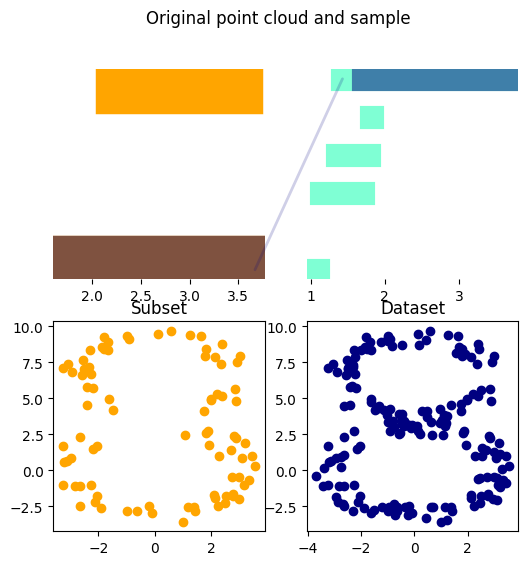

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(Y[:,0], Y[:,1], c="navy")
ax[1,0].set_title("Subset")
ax[1,1].set_title("Dataset")
ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
fig.suptitle("Original point cloud and sample")
plt.savefig("plots/stability/two_circles.png")

Loop through noisy samples of the same pair.

In [8]:
%%capture
rng = default_rng(10)
for idx in range(10):
    eps = 0.1*(1+idx)
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o2 = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    ibfm.plot_matching(IBloFunMatch_o2, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}")
    plt.savefig(f"plots/stability/two_circles{idx}.png")

In [9]:
%%capture
rng = default_rng(10)
eps = 0.4
for idx in range(10):
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o2 = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    ibfm.plot_matching(IBloFunMatch_o2, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}, iteration= {idx}")
    plt.savefig(f"plots/stability/two_circ_noise_const_{idx}.png")

## Perfect Circles Example

In [10]:
r = 3
num_big = 30
num_small=15
angle = np.linspace(0,2*np.pi,num_big)
C1 = np.vstack((r * np.cos(angle), r * np.sin(angle))).transpose()
angle = np.linspace(0,2*np.pi,num_small)
C2 = np.vstack((0.7*r * np.cos(angle), 0.7*r * np.sin(angle))).transpose()+[0,3]
Y=np.vstack((C1,C2))
# Take subset sample
rng = default_rng(5)
subset_indices = list(range(0,num_big,1))+list(range(num_big,num_big+num_small, 2))
center_pts_bool = np.sqrt(np.sum((Y-[0,3])**2, axis=1))<2
subset_indices = [idx for idx in subset_indices if not center_pts_bool[idx]]
X = Y[subset_indices]

In [11]:
%%capture
output_dir="output/"
Dist_X = dist.squareform(dist.pdist(X))
Dist_Y = dist.squareform(dist.pdist(Y))
IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Y, subset_indices, output_dir)

In [12]:
IBloFunMatch_o["pm_matrix"]

[[5], []]

[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685


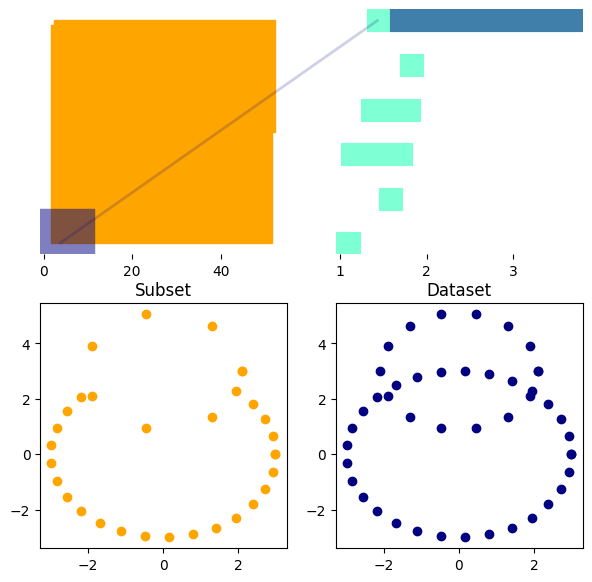

In [13]:
# Plot POints 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7,7))
ax[1,0].scatter(X[:,0], X[:,1], c="orange")
ax[1,1].scatter(Y[:,0], Y[:,1], c="navy")
ax[1,0].set_title("Subset")
ax[1,1].set_title("Dataset")
ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
plt.savefig("plots/perfect_circles/two_circles_perfect.png")

In [14]:
%%capture
rng = default_rng(10)
for i in range(5):
    eps = 0.1 + 0.1*i
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}")
    plt.savefig(f"plots/perfect_circles/two_circles_perfect_{i}.png")

[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685
[1.70189 3.67032] <--> [1.4307  3.67032], strength: 0.685


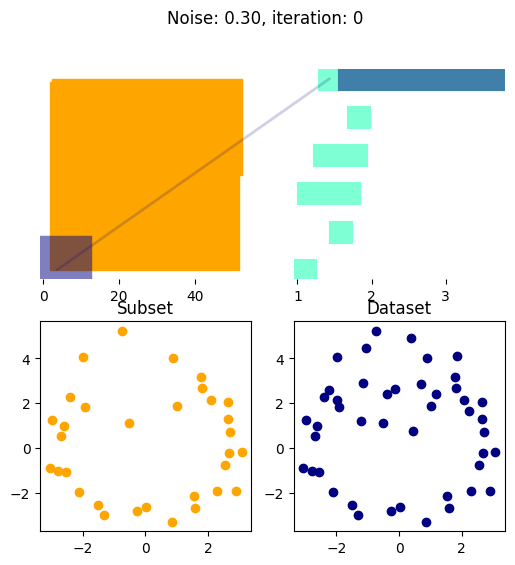

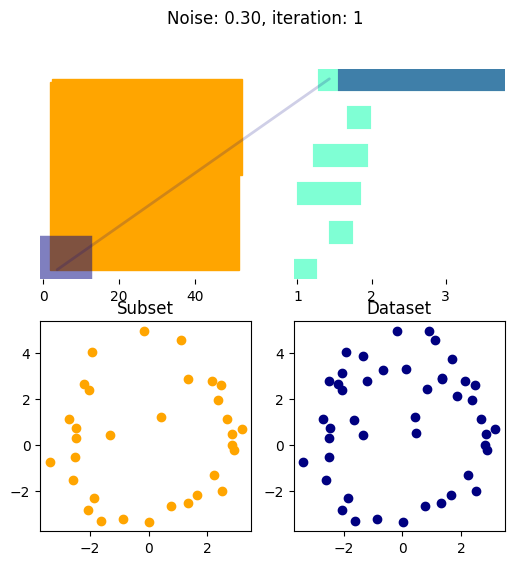

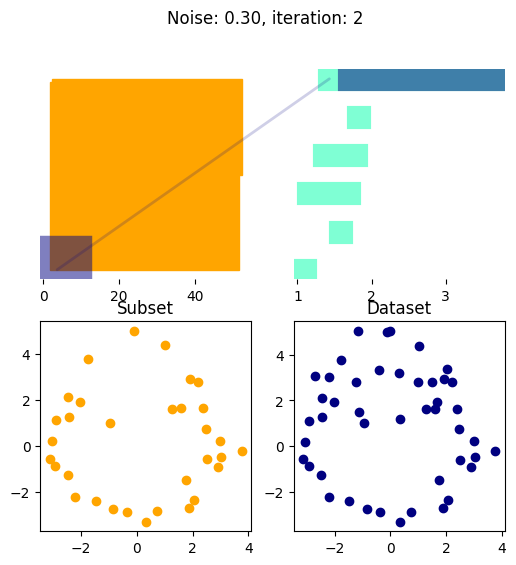

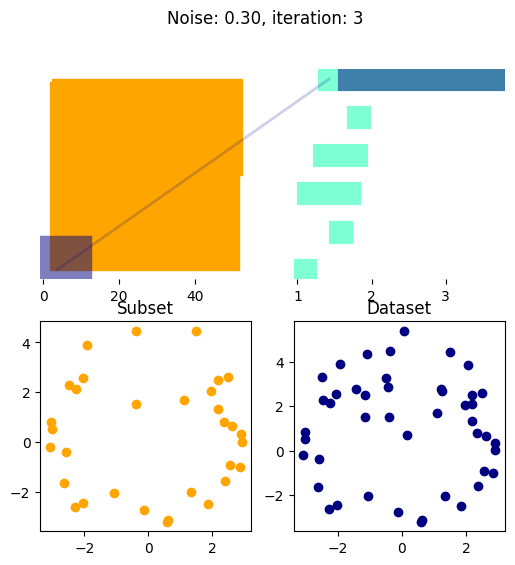

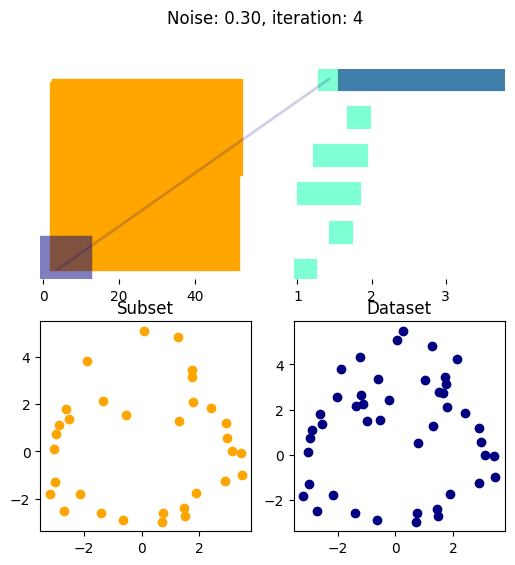

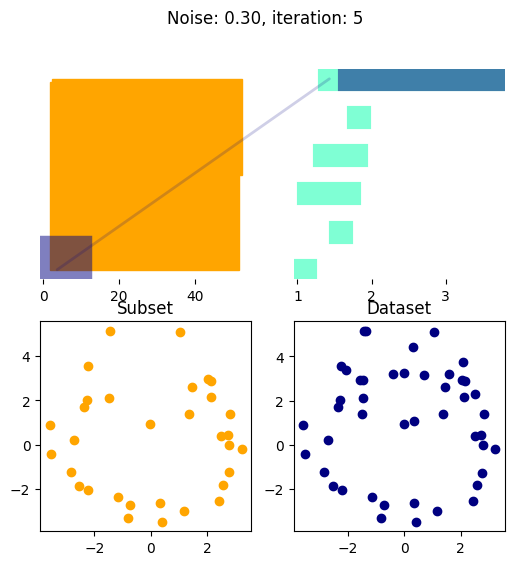

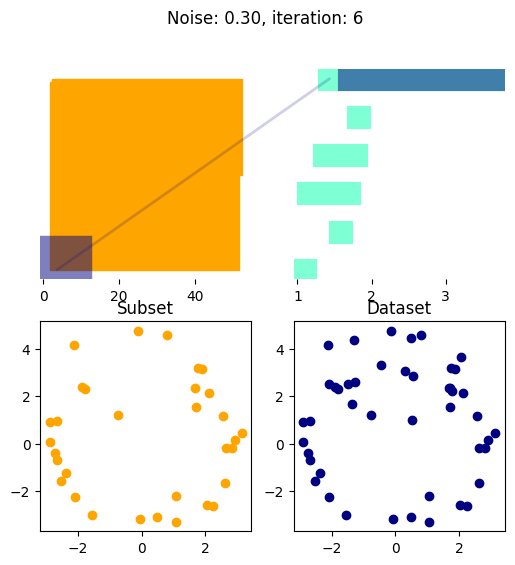

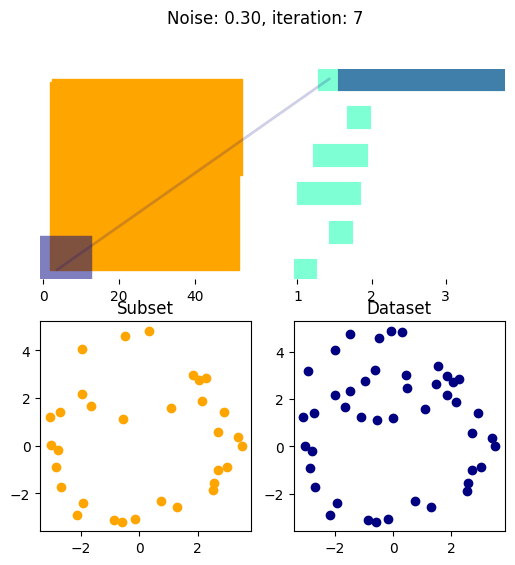

In [15]:
rng = default_rng(10)
eps=0.3
for i in range(8):
    Y2 = Y + rng.normal(size=Y.shape)*eps
    X2 = Y2[subset_indices]
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
    ax[1,0].scatter(X2[:,0], X2[:,1], c="orange")
    ax[1,1].scatter(Y2[:,0], Y2[:,1], c="navy")
    ax[1,0].set_title("Subset")
    ax[1,1].set_title("Dataset")
    output_dir="output/"
    Dist_X2 = dist.squareform(dist.pdist(X2))
    Dist_Y2 = dist.squareform(dist.pdist(Y2))
    IBloFunMatch_o = ibfm.get_IBloFunMatch_subset(Dist_X2, Dist_Y2, subset_indices, output_dir)
    ibfm.plot_matching(IBloFunMatch_o, output_dir, ax[0], fig)
    fig.suptitle(f"Noise: {eps:.2f}, iteration: {i}")
    plt.savefig(f"plots/perfect_circles/two_circ_const_noise_{i}.png")